# Gem Hunting
I would like to know the relative frequency with which gems drop for various actions (to compare with combat).
Furthermore, I need to determine if the probability is the same for any action in a subset of actions or
weighted by the base time (like naturalist). The modes to study are
1. Foraging (Root digging)
2. Mining (default)
3. Mining (prospector)
4. Smithing (refining)

#### Foraging (100 gems each)
- [ ] Grasslands
- [ ] Fungal Grotto
- [ ] Haunted (fewer gems)

#### Mining (100 gems base, 10% uncertainty on snr)
- [ ] Clay pit (no prospector)
- [ ] Clay pit (with prospector)
- [ ] Volcano  (no prospector)
- [ ] Volcano  (with prospector)

#### Smithing (all ore from above, hopefully enough stats)
- [ ] Bronze
- [ ] Rune, Mith, Addy

## Prior
It has been stated that for certain actions, the gem drop distribution is `gem_dist = [40, 30, 20, 7, 3]`, and that the
roll is `if( rndm() < gem_chance ) then choice(gem_dist)` so our test statistic can be on total number of gems
rather than sampling each gem independently. With enough data we may be able to test this hypothesis.

In [1]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark-palette")

In [2]:
plt.style.use("seaborn-dark-palette")
class GemGatherData:
    def __init__(self, **kwargs):
        self.actions = 1
        self.gems = np.array([1, 0, 0, 0, 0])
        self.enchant = 5
        self._update_()
        
    def _update_(self):
        self.totalGems = sum(self.gems)
        self.apg = self.actions / self.totalGems
        
    def setActionsFromDeltaTime(self, tstart, tstop, timer):
        self.setActions( (tstop - tstart)/timer )
        
    def setGems(self, gems):
        self.gems = np.array(gems)
        self._update_()
        
    def setActions(self, actions):
        self.actions = actions
        self._update_()
        
    def __add__(self, other):
        combo = GemGatherData()
        combo.actions = self.actions + other.actions
        combo.gems = self.gems + other.gems
        combo._update_()
        return combo
    
    def getActionProbability(self):
        tg = self.totalGems
        uncert = tg**0.5
        pval = tg / self.actions / self.enchant
        pvhi = uncert/self.actions/self.enchant
        return pval, pvhi
    
    def getTimerProbability(self):
        tg = self.totalGems
        uncert = tg**0.5
        pval = tg / self.actions / self.enchant
        
    def report(self):
        tg = self.totalGems
        uncert = tg**0.5
        apg = self.actions/tg * self.enchant
        apghi = (self.actions * self.enchant)/(tg-uncert) - apg
        apglow = apg - (self.actions * self.enchant)/(tg+uncert)
        pval = tg / self.actions / self.enchant
        pvhi = uncert/self.actions/self.enchant
        print(f'Gem Probability: {pval:0.5f} +- {pvhi:0.5f}')
        print(f'Action-enchant per gem: {apg:0.2f} + {apghi:0.2f} - {apglow:0.2f}')
        
actionTimer = lambda base, lvl, haste: base * 100 / (99 + lvl) * (1 - 0.04*haste)
        
def plotConfidence(ggd, **kwargs):
    f = lambda x, μ, σ: np.exp(-(x-μ)**2/2/σ**2)/(2*np.pi*σ**2)**0.5
    x = np.linspace(0, 0.5e-3, 1000)
    bw = x[1] - x[0]
    mu, sigma = ggd.getActionProbability()
    plt.plot(x, f(x, mu, sigma)*bw, **kwargs)
    plt.ylim(bottom=1e-5)
    return mu, sigma

def baseTimerHypothesis(ggdset, baseset, nameset):
    f = lambda x, μ, σ: np.exp(-(x-μ)**2/2/σ**2)/(2*np.pi*σ**2)**0.5
    fig = plt.figure(figsize=(10,8))
    trials = len(ggdset)
    baseMatrix = np.array([np.array(p.getActionProbability())*b for (p,b) in zip(ggdset, baseset)])
    delta = np.sum(baseMatrix, axis=0)[0] - trials*baseMatrix[0][0]
    uncert = np.sum(baseMatrix**2, axis=0)[1]**0.5
    tension = delta / uncert
    x = np.linspace(0, 1e-2, 1000)
    bw = x[1] - x[0]
    for (bm, name) in zip(baseMatrix, nameset):
        plt.plot(x, f(x, *bm)*bw, label=name)
    plt.ylim(bottom=1e-5)
    plt.title(f'Base timer hypothesis: {tension:0.2f}σ tension')
    plt.xlabel("Base time adjusted probability")
    plt.legend()

In [3]:
## FG
fungal = GemGatherData()
fungal.setActionsFromDeltaTime(1620419087, 1620574242, actionTimer(8, 176, 6))
fungal.setGems([34, 28, 13, 3, 4])
print("Fungal")
fungal.report()

## Haunted
haunted = GemGatherData()
haunted.setActionsFromDeltaTime(1620593916, 1620669929, actionTimer(15, 177, 6))
haunted.setGems([11, 7, 4, 1, 1])
print("Haunted")
haunted.report()

combined = fungal + haunted
print("Combined Results")
combined.report()

Fungal
Gem Probability: 0.00023 +- 0.00003
Action-enchant per gem: 4279.09 + 531.21 - 425.55
Haunted
Gem Probability: 0.00026 +- 0.00005
Action-enchant per gem: 3833.99 + 983.33 - 649.94
Combined Results
Gem Probability: 0.00024 +- 0.00002
Action-enchant per gem: 4178.31 + 449.49 - 369.90


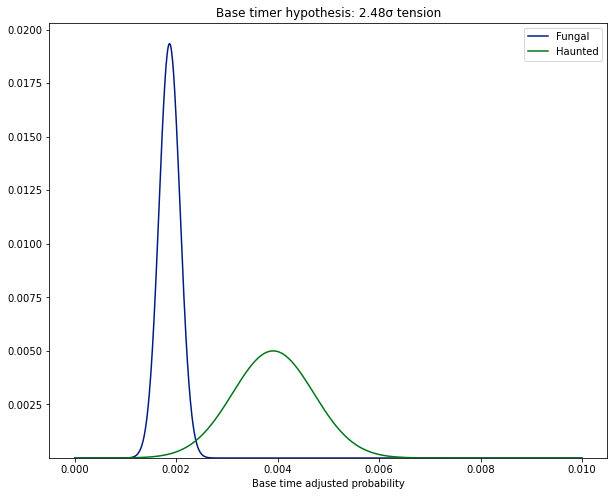

In [4]:
# Root digging, base timer adjusted hypothesis. This test is to determine if the probability is adjusted
# by the base timer or not, results show that the base timer so far does not affect root digging.
baseTimerHypothesis([fungal, haunted], [8, 15], ["Fungal", "Haunted"])
plt.show()

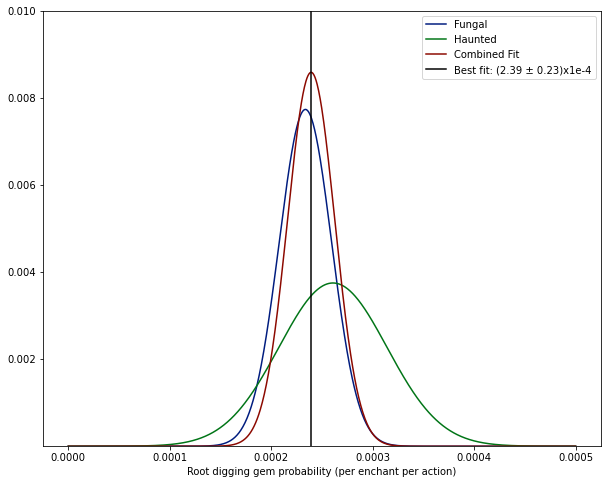

In [5]:
fig = plt.figure(figsize=(10,8))
plotConfidence(fungal, label="Fungal")
plotConfidence(haunted, label="Haunted")
m, s = plotConfidence(combined, label="Combined Fit")
plt.ylim(top=0.01)
plt.xlabel("Root digging gem probability (per enchant per action)")
plt.axvline(m, color="xkcd:black", label=f'Best fit: ({m * 1e4:0.2f} ± {s * 1e4:0.2f})x1e-4')
plt.legend()
plt.show()